In [1]:
# pip install tensorflow

In [1]:
import pandas as pd
import os
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Path to the folder containing the data
data_folder = r'C:\Users\Sushmeet Kaur\OneDrive\Desktop\FinAssist\NSE_Data'

# List of companies and their respective file names
file_paths = {
    'BHARTIARTL': os.path.join(data_folder, 'BHARTIARTL', 'BHARTIARTL_historical_data.csv'),
    'EICHERMOT': os.path.join(data_folder, 'EICHERMOT', 'EICHERMOT_historical_data.csv'),
    'HEROMOTOCO': os.path.join(data_folder, 'HEROMOTOCO', 'HEROMOTOCO_historical_data.csv'),
    'MM': os.path.join(data_folder, 'M&M', 'M&M_historical_data.csv'),
    'TATASTEEL': os.path.join(data_folder, 'TATASTEEL', 'TATASTEEL_historical_data.csv')
}

# Loading Excel files into separate dataframes
dfs = {company: pd.read_csv(path) for company, path in file_paths.items()}

# Checking the first few rows of one dataframe to verify
dfs['BHARTIARTL'].head()

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,05-May-2025,EQ,"1,868.00","1,873.50","1,849.20","1,851.90","1,866.00","1,866.00","1,864.43","1,904.30","1,219.05","35,48,839","6,61,65,47,877.00","1,03,413"
1,02-May-2025,EQ,"1,852.00","1,883.60","1,832.10","1,864.50","1,849.00","1,851.90","1,854.96","1,904.30","1,219.05","55,28,529","10,25,52,09,665.90","1,81,226"
2,30-Apr-2025,EQ,"1,837.00","1,876.90","1,827.00","1,823.80","1,854.80","1,864.50","1,854.65","1,904.30","1,219.05","91,39,821","16,95,11,67,803.70","1,52,336"
3,29-Apr-2025,EQ,"1,823.70","1,847.80","1,817.60","1,821.80","1,827.20","1,823.80","1,829.51","1,904.30","1,219.05","46,84,155","8,56,96,95,123.70","1,53,385"
4,28-Apr-2025,EQ,"1,836.00","1,838.90","1,813.40","1,817.20","1,820.30","1,821.80","1,822.30","1,904.30","1,219.05","33,01,891","6,01,70,36,292.30","1,00,779"


In [2]:
def clean_and_preprocess(df):
    # Step 1: Clean column names
    df.columns = [col.strip().lower().replace(' ', '_').replace('.', '').replace('/', '_') for col in df.columns]
    
    # Step 2: Convert 'date' to datetime
    df['date'] = pd.to_datetime(df['date'], format='%d-%b-%Y')
    
    # Step 3: Remove commas and convert VOLUME, VALUE, NO_OF_TRADES to numeric
    for col in ['volume', 'value', 'no_of_trades']:
        df[col] = df[col].astype(str).str.replace(',', '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Step 4: Sort by date
    df = df.sort_values('date').reset_index(drop=True)
    
    return df

# Apply preprocessing to all company dataframes
for company in dfs:
    dfs[company] = clean_and_preprocess(dfs[company])

# Now dfs[company] holds the cleaned dataframes


In [3]:
for company, df in dfs.items():
    print(f"\nCompany: {company}")
    print("Date Range:", df['date'].min().date(), "to", df['date'].max().date())
    print("Missing Values:\n", df.isnull().sum())
    print("Data Types:\n", df.dtypes)
    print("First few rows:\n", df.head(2))


Company: BHARTIARTL
Date Range: 2024-05-06 to 2025-05-05
Missing Values:
 date            0
series          0
open            0
high            0
low             0
prev_close      0
ltp             0
close           0
vwap            0
52w_h           0
52w_l           0
volume          0
value           0
no_of_trades    0
dtype: int64
Data Types:
 date            datetime64[ns]
series                  object
open                    object
high                    object
low                     object
prev_close              object
ltp                     object
close                   object
vwap                    object
52w_h                   object
52w_l                   object
volume                   int64
value                  float64
no_of_trades             int64
dtype: object
First few rows:
         date series      open      high       low prev_close       ltp  \
0 2024-05-06     EQ  1,275.00  1,298.45  1,273.20   1,277.40  1,282.75   
1 2024-05-07     EQ  1,286.35  1,2

In [4]:
def preprocess_dataframe(df):
    price_cols = ['open', 'high', 'low', 'prev_close', 'ltp', 'close', 'vwap', '52w_h', '52w_l']
    for col in price_cols:
        df[col] = df[col].str.replace(',', '').astype(float)
    return df

In [5]:
df_bhartiartl = dfs['BHARTIARTL']
df_eichermot = dfs['EICHERMOT']
df_heromotoco = dfs['HEROMOTOCO']
df_mm = dfs['MM']
df_tatasteel = dfs['TATASTEEL']

In [6]:
df_bhartiartl = preprocess_dataframe(df_bhartiartl)
df_eichermot = preprocess_dataframe(df_eichermot)
df_heromotoco = preprocess_dataframe(df_heromotoco)
df_mm = preprocess_dataframe(df_mm)
# df_tatasteel already has float values, no need to preprocess


--- BHARTIARTL ---
Shape: (248, 14)
Data Types:
 date            datetime64[ns]
series                  object
open                   float64
high                   float64
low                    float64
prev_close             float64
ltp                    float64
close                  float64
vwap                   float64
52w_h                  float64
52w_l                  float64
volume                   int64
value                  float64
no_of_trades             int64
dtype: object
Missing Values:
 date            0
series          0
open            0
high            0
low             0
prev_close      0
ltp             0
close           0
vwap            0
52w_h           0
52w_l           0
volume          0
value           0
no_of_trades    0
dtype: int64


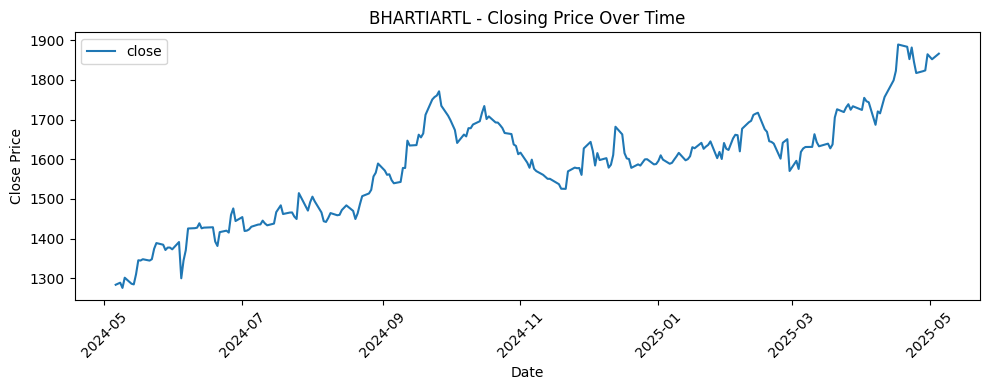

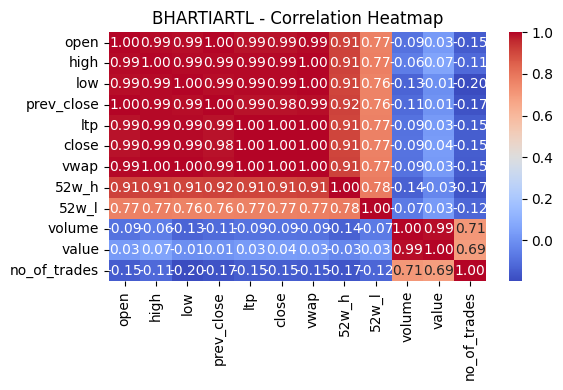


--- EICHERMOT ---
Shape: (248, 14)
Data Types:
 date            datetime64[ns]
series                  object
open                   float64
high                   float64
low                    float64
prev_close             float64
ltp                    float64
close                  float64
vwap                   float64
52w_h                  float64
52w_l                  float64
volume                   int64
value                  float64
no_of_trades             int64
dtype: object
Missing Values:
 date            0
series          0
open            0
high            0
low             0
prev_close      0
ltp             0
close           0
vwap            0
52w_h           0
52w_l           0
volume          0
value           0
no_of_trades    0
dtype: int64


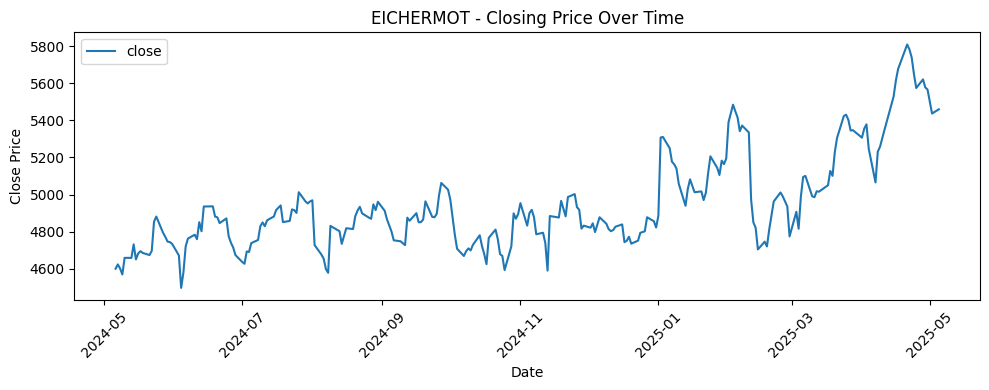

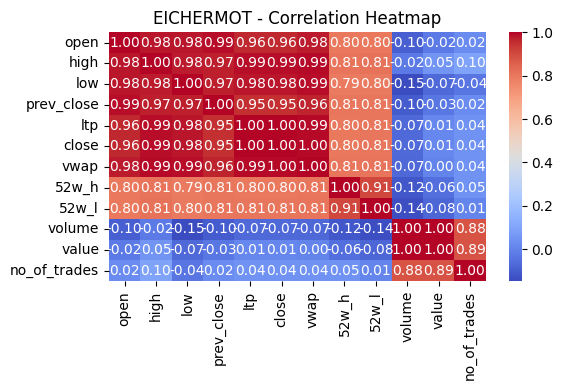


--- HEROMOTOCO ---
Shape: (248, 14)
Data Types:
 date            datetime64[ns]
series                  object
open                   float64
high                   float64
low                    float64
prev_close             float64
ltp                    float64
close                  float64
vwap                   float64
52w_h                  float64
52w_l                  float64
volume                   int64
value                  float64
no_of_trades             int64
dtype: object
Missing Values:
 date            0
series          0
open            0
high            0
low             0
prev_close      0
ltp             0
close           0
vwap            0
52w_h           0
52w_l           0
volume          0
value           0
no_of_trades    0
dtype: int64


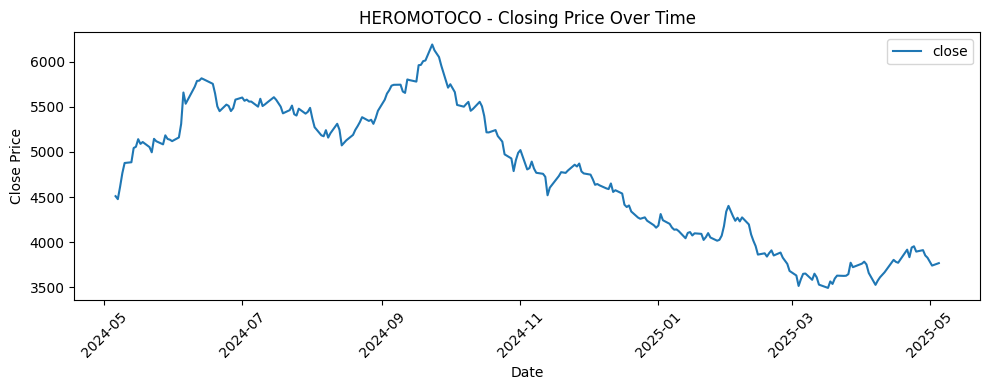

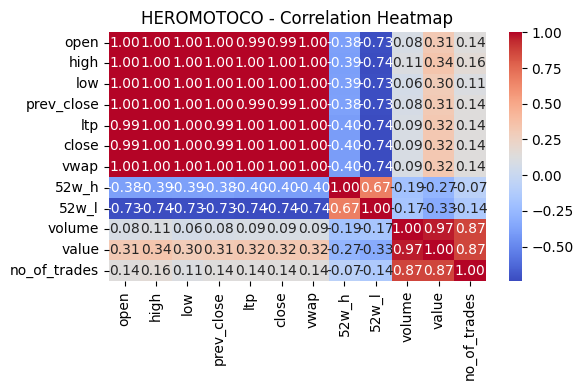


--- MM ---
Shape: (248, 14)
Data Types:
 date            datetime64[ns]
series                  object
open                   float64
high                   float64
low                    float64
prev_close             float64
ltp                    float64
close                  float64
vwap                   float64
52w_h                  float64
52w_l                  float64
volume                   int64
value                  float64
no_of_trades             int64
dtype: object
Missing Values:
 date            0
series          0
open            0
high            0
low             0
prev_close      0
ltp             0
close           0
vwap            0
52w_h           0
52w_l           0
volume          0
value           0
no_of_trades    0
dtype: int64


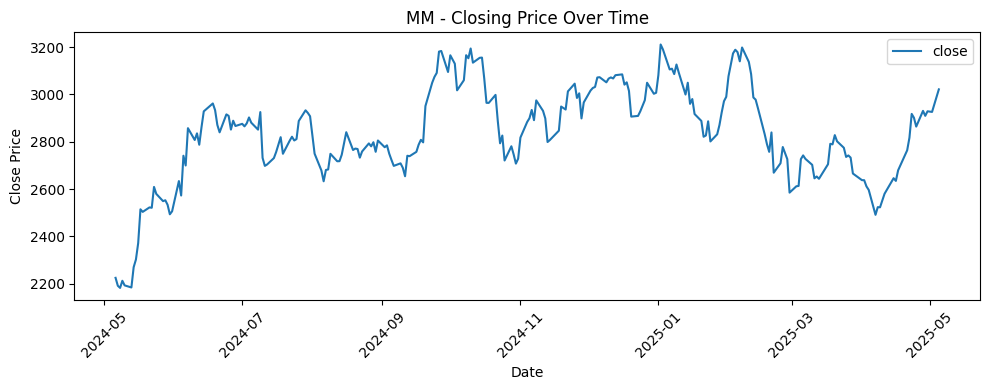

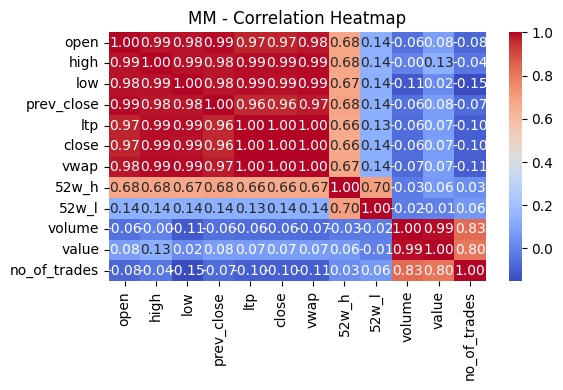


--- TATASTEEL ---
Shape: (248, 14)
Data Types:
 date            datetime64[ns]
series                  object
open                   float64
high                   float64
low                    float64
prev_close             float64
ltp                    float64
close                  float64
vwap                   float64
52w_h                  float64
52w_l                  float64
volume                   int64
value                  float64
no_of_trades             int64
dtype: object
Missing Values:
 date            0
series          0
open            0
high            0
low             0
prev_close      0
ltp             0
close           0
vwap            0
52w_h           0
52w_l           0
volume          0
value           0
no_of_trades    0
dtype: int64


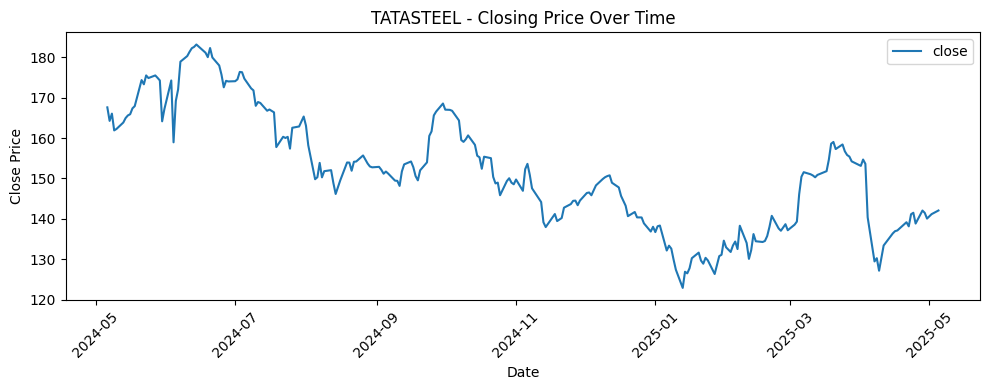

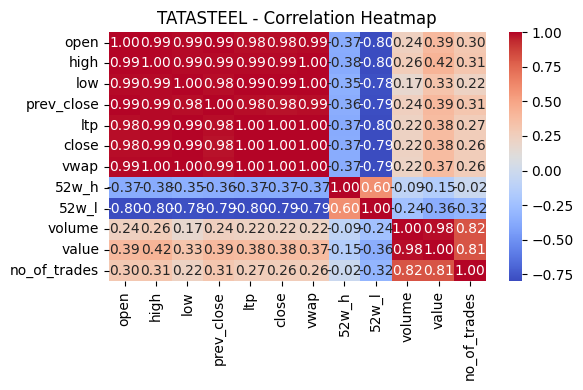

In [7]:
for company, df in dfs.items():
    print(f"\n--- {company} ---")
    print("Shape:", df.shape)
    print("Data Types:\n", df.dtypes)
    print("Missing Values:\n", df.isnull().sum())
    
    # Plot closing price
    plt.figure(figsize=(10, 4))
    plt.plot(df['date'], df['close'], label='close')
    plt.title(f"{company} - Closing Price Over Time")
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Correlation heatmap
    numeric_cols = df.select_dtypes(include='number')
    plt.figure(figsize=(6, 4))
    sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f"{company} - Correlation Heatmap")
    plt.tight_layout()
    plt.show()

In [8]:
def create_sequences(df, window_size=30):
    features = ['open', 'high', 'low', 'prev_close', 'ltp', 'close', 'vwap', '52w_h', '52w_l', 'volume', 'value', 'no_of_trades']

    # Convert to numeric and remove commas
    for col in features:
        df[col] = df[col].astype(str).str.replace(',', '').astype(float)

    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df[features])  # scale all selected features

    X, y = [], []
    for i in range(window_size, len(df_scaled)):
        X.append(df_scaled[i - window_size:i])                # 30 timesteps
        y.append(df_scaled[i, features.index('close')])       # predict normalized close price

    X, y = np.array(X), np.array(y)
    return X, y, scaler

company_data = {}
for company, df in dfs.items():
    X, y, scaler = create_sequences(df, window_size=30)
    company_data[company] = {'X': X, 'y': y, 'scaler': scaler}

company_data['BHARTIARTL']['X'].shape, company_data['BHARTIARTL']['y'].shape


((218, 30, 12), (218,))

In [9]:
def split_data(X, y, train_size=0.8, validation_size=0.1, test_size=0.1):
    # First split into train + temp (train + validation)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, shuffle=False)
    
    # Now split the remaining data (temp) into validation and test sets
    validation_size_adjusted = validation_size / (validation_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=validation_size_adjusted, shuffle=False)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Split data for each company
company_splits = {}
for company, data in company_data.items():
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(data['X'], data['y'])
    company_splits[company] = {
        'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
        'scaler': data['scaler']  # include scaler for inverse transform later
    }

# Check the shapes of the splits for one company
company_splits['BHARTIARTL']['X_train'].shape, company_splits['BHARTIARTL']['X_val'].shape, company_splits['BHARTIARTL']['X_test'].shape

((174, 30, 12), (22, 30, 12), (22, 30, 12))

In [11]:
def build_lstm_model(input_shape):
    model = Sequential()

    # Adding LSTM layers
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.2))

    # Fully connected layer for output
    model.add(Dense(units=1))

    # Compiling the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Save the model to the specified path
    model.save(r'C:\Users\Sushmeet Kaur\OneDrive\Desktop\FinAssist\historical_data_model.h5')
    print("Model successfully saved to downloads folder")

    return model

# Define input shape for LSTM (time steps, features)
# Ensure X_train is properly defined (assuming you have already split your data)
input_shape = (X_train.shape[1], X_train.shape[2])

# Build the LSTM model
lstm_model = build_lstm_model(input_shape)

# Summarize the model
lstm_model.summary()

Model successfully saved to downloads folder


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 30, 64)              │          19,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,801 (206.25 KB)

 Trainable params: 52,801 (206.25 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.2833 - val_loss: 0.0208
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0650 - val_loss: 0.0523
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0309 - val_loss: 0.0555
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0210 - val_loss: 0.0136
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0240 - val_loss: 0.0300
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0131 - val_loss: 0.0430
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0138 - val_loss: 0.0256
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0096 - val_loss: 0.0216
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0111 - val_loss: 0.0328
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0113 - val_loss: 0.0270
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0099 - val_loss: 0.0181
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0103 - val_loss: 0.0193
E

In [13]:

# # Saving the trained Keras model to the Downloads folder (recommended way)
# import os

# # downloads_path = os.path.join(os.path.expanduser("~"), "Downloads", "close_price_prediction_model.h5")
# model.save(r"C:\Users\Sushmeet Kaur\Downloads\close_price_prediction_model.h5")
# print("Model successfully saved to:", downloads_path)

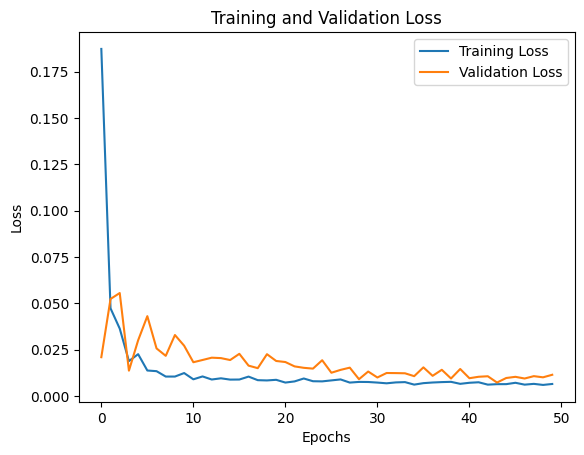

In [14]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/50


C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.1662 - val_loss: 0.0381
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0356 - val_loss: 0.0105
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0138 - val_loss: 0.0198
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0126 - val_loss: 0.0077
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0115 - val_loss: 0.0073
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0079 - val_loss: 0.0091
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0080 - val_loss: 0.0071
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0058 - val_loss: 0.0078
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0066 - val_loss: 0.0079
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0064 - val_loss: 0.0071
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0068 - val_loss: 0.0081
Epoch 13/50


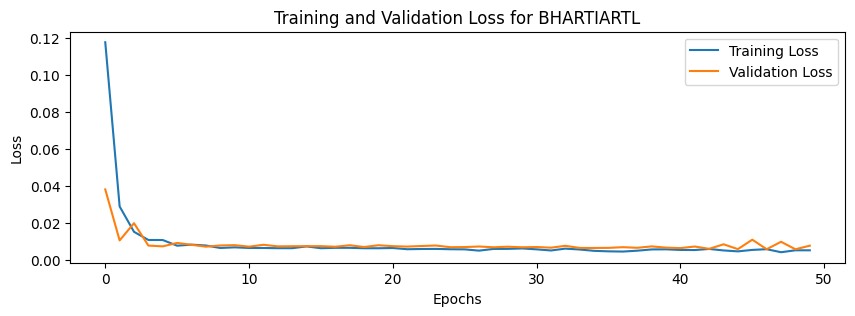

Epoch 1/50


C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0731 - val_loss: 0.0184
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0244 - val_loss: 0.0227
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0152 - val_loss: 0.0514
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0198 - val_loss: 0.0378
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0142 - val_loss: 0.0201
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0144 - val_loss: 0.0195
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0140 - val_loss: 0.0289
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0137 - val_loss: 0.0291
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0108 - val_loss: 0.0245
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0130 - val_loss: 0.0197
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0127 - val_loss: 0.0280
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0119 - val_loss: 0.0263
Epoch 13/50


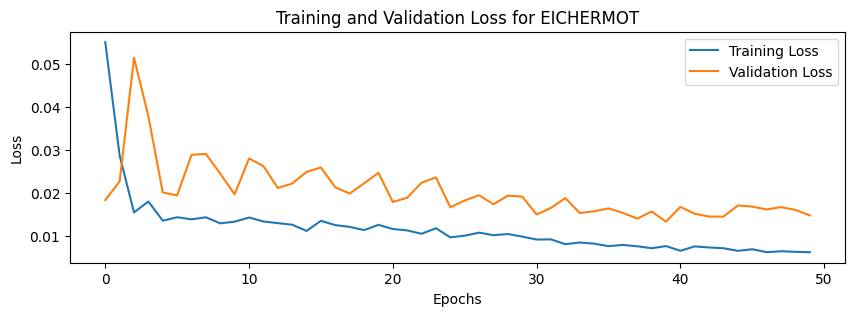

Epoch 1/50


C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.2729 - val_loss: 0.0334
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0384 - val_loss: 0.0204
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0190 - val_loss: 0.0100
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0181 - val_loss: 0.0220
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0131 - val_loss: 0.0248
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0121 - val_loss: 0.0124
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0108 - val_loss: 0.0125
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0090 - val_loss: 0.0127
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0092 - val_loss: 0.0076
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0078 - val_loss: 0.0053
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0072 - val_loss: 0.0064
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0099 - val_loss: 0.0035
Epoch 13/50


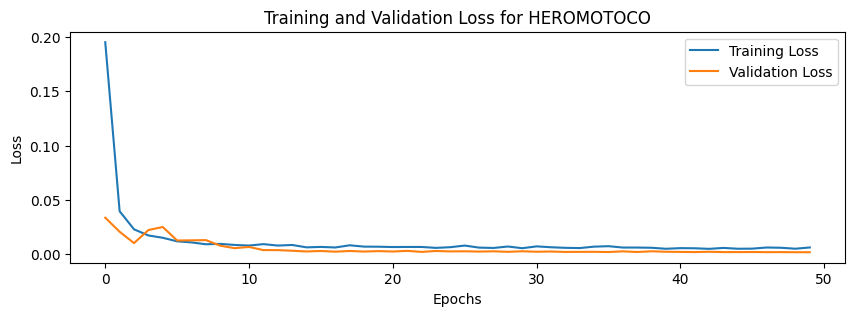

Epoch 1/50


C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.3544 - val_loss: 0.0394
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0497 - val_loss: 0.0224
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0271 - val_loss: 0.0098
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0330 - val_loss: 0.0125
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0224 - val_loss: 0.0369
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0281 - val_loss: 0.0136
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0163 - val_loss: 0.0101
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0200 - val_loss: 0.0166
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0197 - val_loss: 0.0164
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0168 - val_loss: 0.0115
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0155 - val_loss: 0.0129
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0185 - val_loss: 0.0129
Epoch 13/50


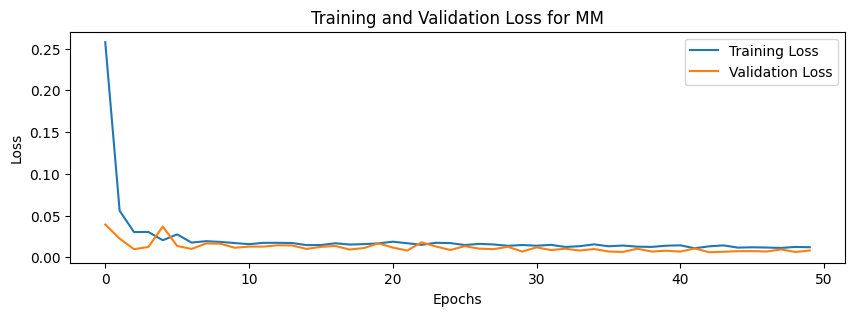

Epoch 1/50


C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.1952 - val_loss: 0.0095
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0346 - val_loss: 0.0228
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0176 - val_loss: 0.0340
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0146 - val_loss: 0.0137
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0126 - val_loss: 0.0077
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0142 - val_loss: 0.0178
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0136 - val_loss: 0.0163
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0098 - val_loss: 0.0144
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0109 - val_loss: 0.0151
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0090 - val_loss: 0.0180
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0091 - val_loss: 0.0165
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0104 - val_loss: 0.0164
Epoch 13/50


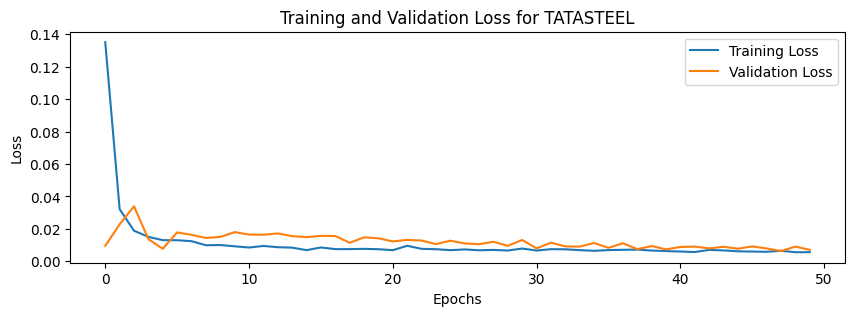

In [15]:
# Function to normalize data and create sequences
def create_sequences(df, window_size=30):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df[['close']])  # Normalize only the 'close' column
    
    # Creating the sequences
    X = []
    y = []
    
    for i in range(window_size, len(df_scaled)):
        X.append(df_scaled[i-window_size:i, 0])  # Sequence of 30 days (window_size)
        y.append(df_scaled[i, 0])  # The next day's closing price
    
    # Convert to numpy arrays
    X, y = np.array(X), np.array(y)
    
    # Reshape X for LSTM [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y, scaler

# Function to split data into training, validation, and test sets
def split_data(X, y, train_size=0.8, validation_size=0.1, test_size=0.1):
    # First split into train + temp (train + validation)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, shuffle=False)
    
    # Now split the remaining data (temp) into validation and test sets
    validation_size_adjusted = validation_size / (validation_size + test_size)  # Adjust the ratio for validation and test
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=validation_size_adjusted, shuffle=False)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Function to build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()

    # Adding LSTM layers
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.2))

    # Fully connected layer for output
    model.add(Dense(units=1))

    # Compiling the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    

    return model

# Create sequences for each company and train separate models
company_data = {}
company_models = {}

for company, df in dfs.items():  # Assuming 'dfs' is the dictionary containing dataframes for each company
    X, y, scaler = create_sequences(df, window_size=30)
    company_data[company] = {'X': X, 'y': y, 'scaler': scaler}
    
    # Split the data into training, validation, and test sets
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
    
    # Define input shape for LSTM (samples, time steps, features)
    input_shape = (X_train.shape[1], X_train.shape[2])

    # Build the LSTM model
    lstm_model = build_lstm_model(input_shape)
    
    # Train the model
    history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))
    
    # Save the trained model for each company
    company_models[company] = lstm_model
    
    # Plotting the training and validation loss curves for each company
    plt.figure(figsize=(10, 3))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {company}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Now 'company_models' contains the LSTM model for each company


Epoch 1/50


C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.1430 - val_loss: 0.0488
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0330 - val_loss: 0.0130
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0116 - val_loss: 0.0177
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0124 - val_loss: 0.0082
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0102 - val_loss: 0.0074
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0080 - val_loss: 0.0107
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0070 - val_loss: 0.0080
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0075 - val_loss: 0.0086
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0062 - val_loss: 0.0081
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0057 - val_loss: 0.0072
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0071 - val_loss: 0.0083
Epoch 13/50


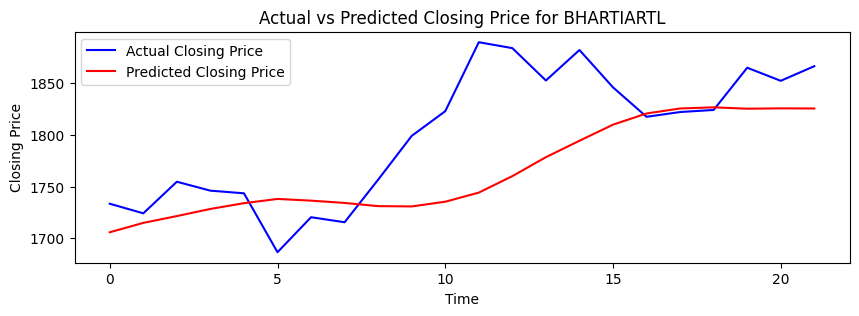

Epoch 1/50


C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.1046 - val_loss: 0.0257
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0256 - val_loss: 0.0272
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0170 - val_loss: 0.0492
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0175 - val_loss: 0.0329
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0148 - val_loss: 0.0210
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0147 - val_loss: 0.0265
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0137 - val_loss: 0.0305
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0129 - val_loss: 0.0252
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0136 - val_loss: 0.0247
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0142 - val_loss: 0.0245
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0124 - val_loss: 0.0291
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0136 - val_loss: 0.0239
Epoch 13/50


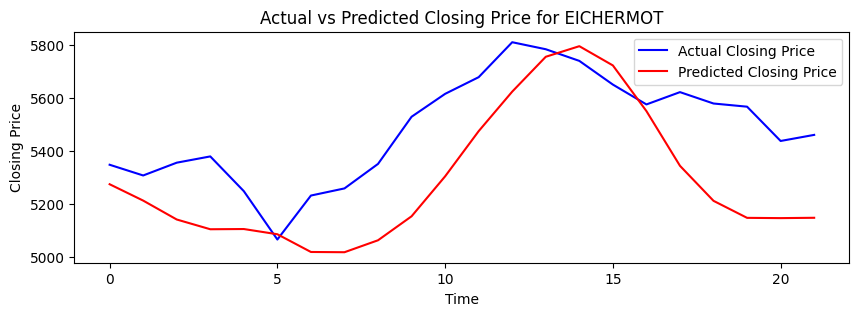

Epoch 1/50


C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.1893 - val_loss: 0.0495
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0484 - val_loss: 0.0134
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0188 - val_loss: 0.0081
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0165 - val_loss: 0.0192
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0131 - val_loss: 0.0168
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0108 - val_loss: 0.0098
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0096 - val_loss: 0.0097
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0108 - val_loss: 0.0105
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0092 - val_loss: 0.0056
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0084 - val_loss: 0.0044
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0071 - val_loss: 0.0047
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0077 - val_loss: 0.0033
Epoch 13/50


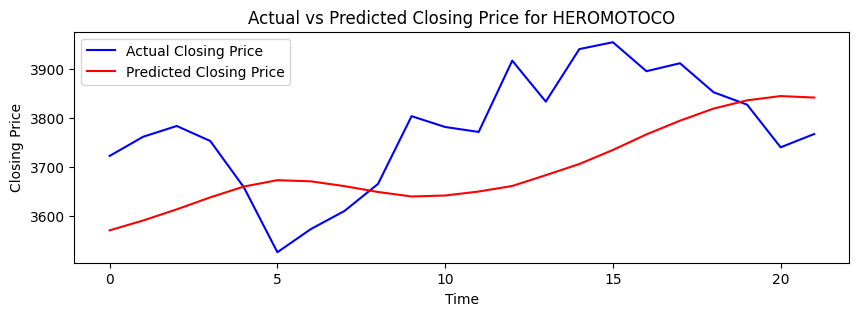

Epoch 1/50


C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.3594 - val_loss: 0.1136
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0813 - val_loss: 0.0181
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0328 - val_loss: 0.0102
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0396 - val_loss: 0.0162
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0235 - val_loss: 0.0472
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0284 - val_loss: 0.0194
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0189 - val_loss: 0.0132
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0207 - val_loss: 0.0185
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0193 - val_loss: 0.0217
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0182 - val_loss: 0.0203
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0192 - val_loss: 0.0172
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0163 - val_loss: 0.0200
Epoch 13/50


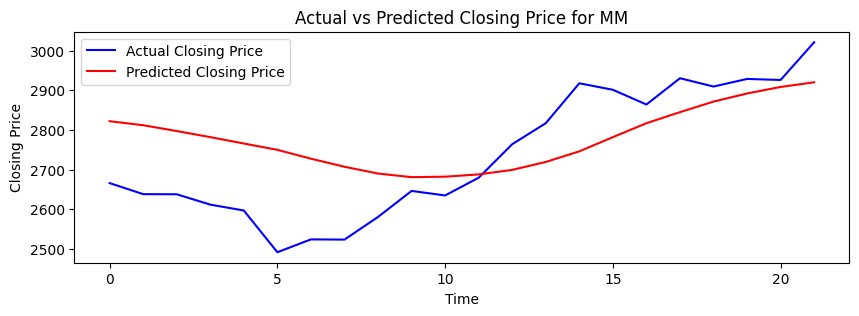

Epoch 1/50


C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.1372 - val_loss: 0.0069
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0324 - val_loss: 0.0249
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0146 - val_loss: 0.0314
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0150 - val_loss: 0.0162
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0126 - val_loss: 0.0166
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0128 - val_loss: 0.0196
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0113 - val_loss: 0.0169
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0109 - val_loss: 0.0220
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0080 - val_loss: 0.0196
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0092 - val_loss: 0.0161
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0085 - val_loss: 0.0234
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0089 - val_loss: 0.0145
Epoch 13/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


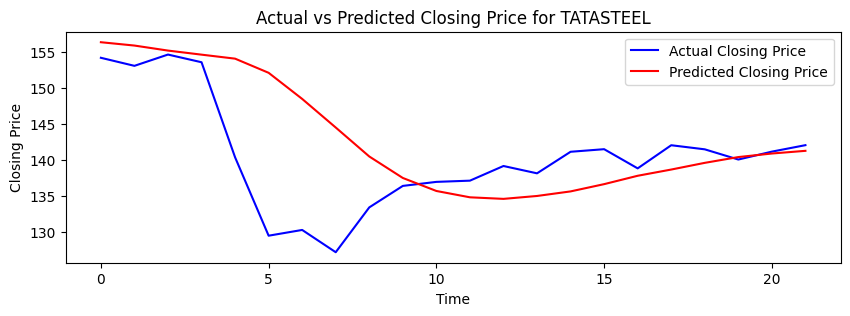

In [16]:
# Function to plot actual vs predicted closing prices
def plot_actual_vs_predicted(company, y_test, predicted_prices):
    plt.figure(figsize=(10, 3))
    plt.plot(y_test, color='blue', label='Actual Closing Price')
    plt.plot(predicted_prices, color='red', label='Predicted Closing Price')
    plt.title(f'Actual vs Predicted Closing Price for {company}')
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

# Create sequences for each company and train separate models
company_data = {}
company_models = {}

for company, df in dfs.items():  # Assuming 'dfs' is the dictionary containing dataframes for each company
    X, y, scaler = create_sequences(df, window_size=30)
    company_data[company] = {'X': X, 'y': y, 'scaler': scaler}
    
    # Split the data into training, validation, and test sets
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
    
    # Define input shape for LSTM (samples, time steps, features)
    input_shape = (X_train.shape[1], X_train.shape[2])

    # Build the LSTM model
    lstm_model = build_lstm_model(input_shape)
    
    # Train the model
    history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))
    
    # Save the trained model for each company
    company_models[company] = lstm_model
    
    # Predict on the test set
    predicted_prices = lstm_model.predict(X_test)
    
    # Inverse transform the predicted prices and the actual test prices to their original scale
    predicted_prices = scaler.inverse_transform(predicted_prices)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # Reshape y_test to 2D for inverse transformation
    
    # Plot the actual vs predicted closing prices
    plot_actual_vs_predicted(company, y_test_actual, predicted_prices)

# Now 'company_models' contains the LSTM model for each company, and you have actual vs predicted plots


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# Dictionary to store model performance for each company
model_performance = {}

for company, model in company_models.items():
    data = company_data[company]
    X, y, scaler = data['X'], data['y'], data['scaler']
    
    # Re-split the data to get test set
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
    
    # Predict on test set
    predicted = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    predicted_prices = scaler.inverse_transform(predicted)
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(actual_prices, predicted_prices)
    mse = mean_squared_error(actual_prices, predicted_prices)
    rmse = math.sqrt(mse)
    r2 = r2_score(actual_prices, predicted_prices)
    
    # Store metrics
    model_performance[company] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2 Score': r2
    }
    
    # Print metrics
    print(f"\nPerformance for {company}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Performance for BHARTIARTL:
MAE: 42.9773
MSE: 3322.0807
RMSE: 57.6375
R² Score: 0.1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Performance for EICHERMOT:
MAE: 204.2522
MSE: 56372.0627
RMSE: 237.4280
R² Score: -0.4873
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Performance for HEROMOTOCO:
MAE: 121.2612
MSE: 19408.1647
RMSE: 139.3132
R² Score: -0.4988
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Performance for MM:
MAE: 111.6540
MSE: 17095.7064
RMSE: 130.7506
R² Score: 0.3312
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Performance for TATASTEEL:
MAE: 5.2800
MSE: 68.6584
RMSE: 8.2860
R² Score: -0.2247


In [18]:
# Save the trained model for each company
company_models[company] = lstm_model

In [19]:
# Save the trained model for each company
company_models[company] = lstm_model
lstm_model.save(f"{company}_model.h5")
print(f"Saved model for {company} as {company}_model.h5")

Saved model for TATASTEEL as TATASTEEL_model.h5
